In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import os
import pickle
from multiprocessing import Process
import random
from feature_selection import feature_ranking_algorithm
import time

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
data_path = "D:/work/fsorfl/Final A(1)/Final A/code_report/code/RFLFSODataFull.csv"
root_dir = "D:/work/fsorfl/Final A(1)/Final A/code_report/code/"

In [3]:
def load_data():
    df = pd.read_csv(data_path)
    return df

original_data = load_data()

<Figure size 1200x1200 with 0 Axes>

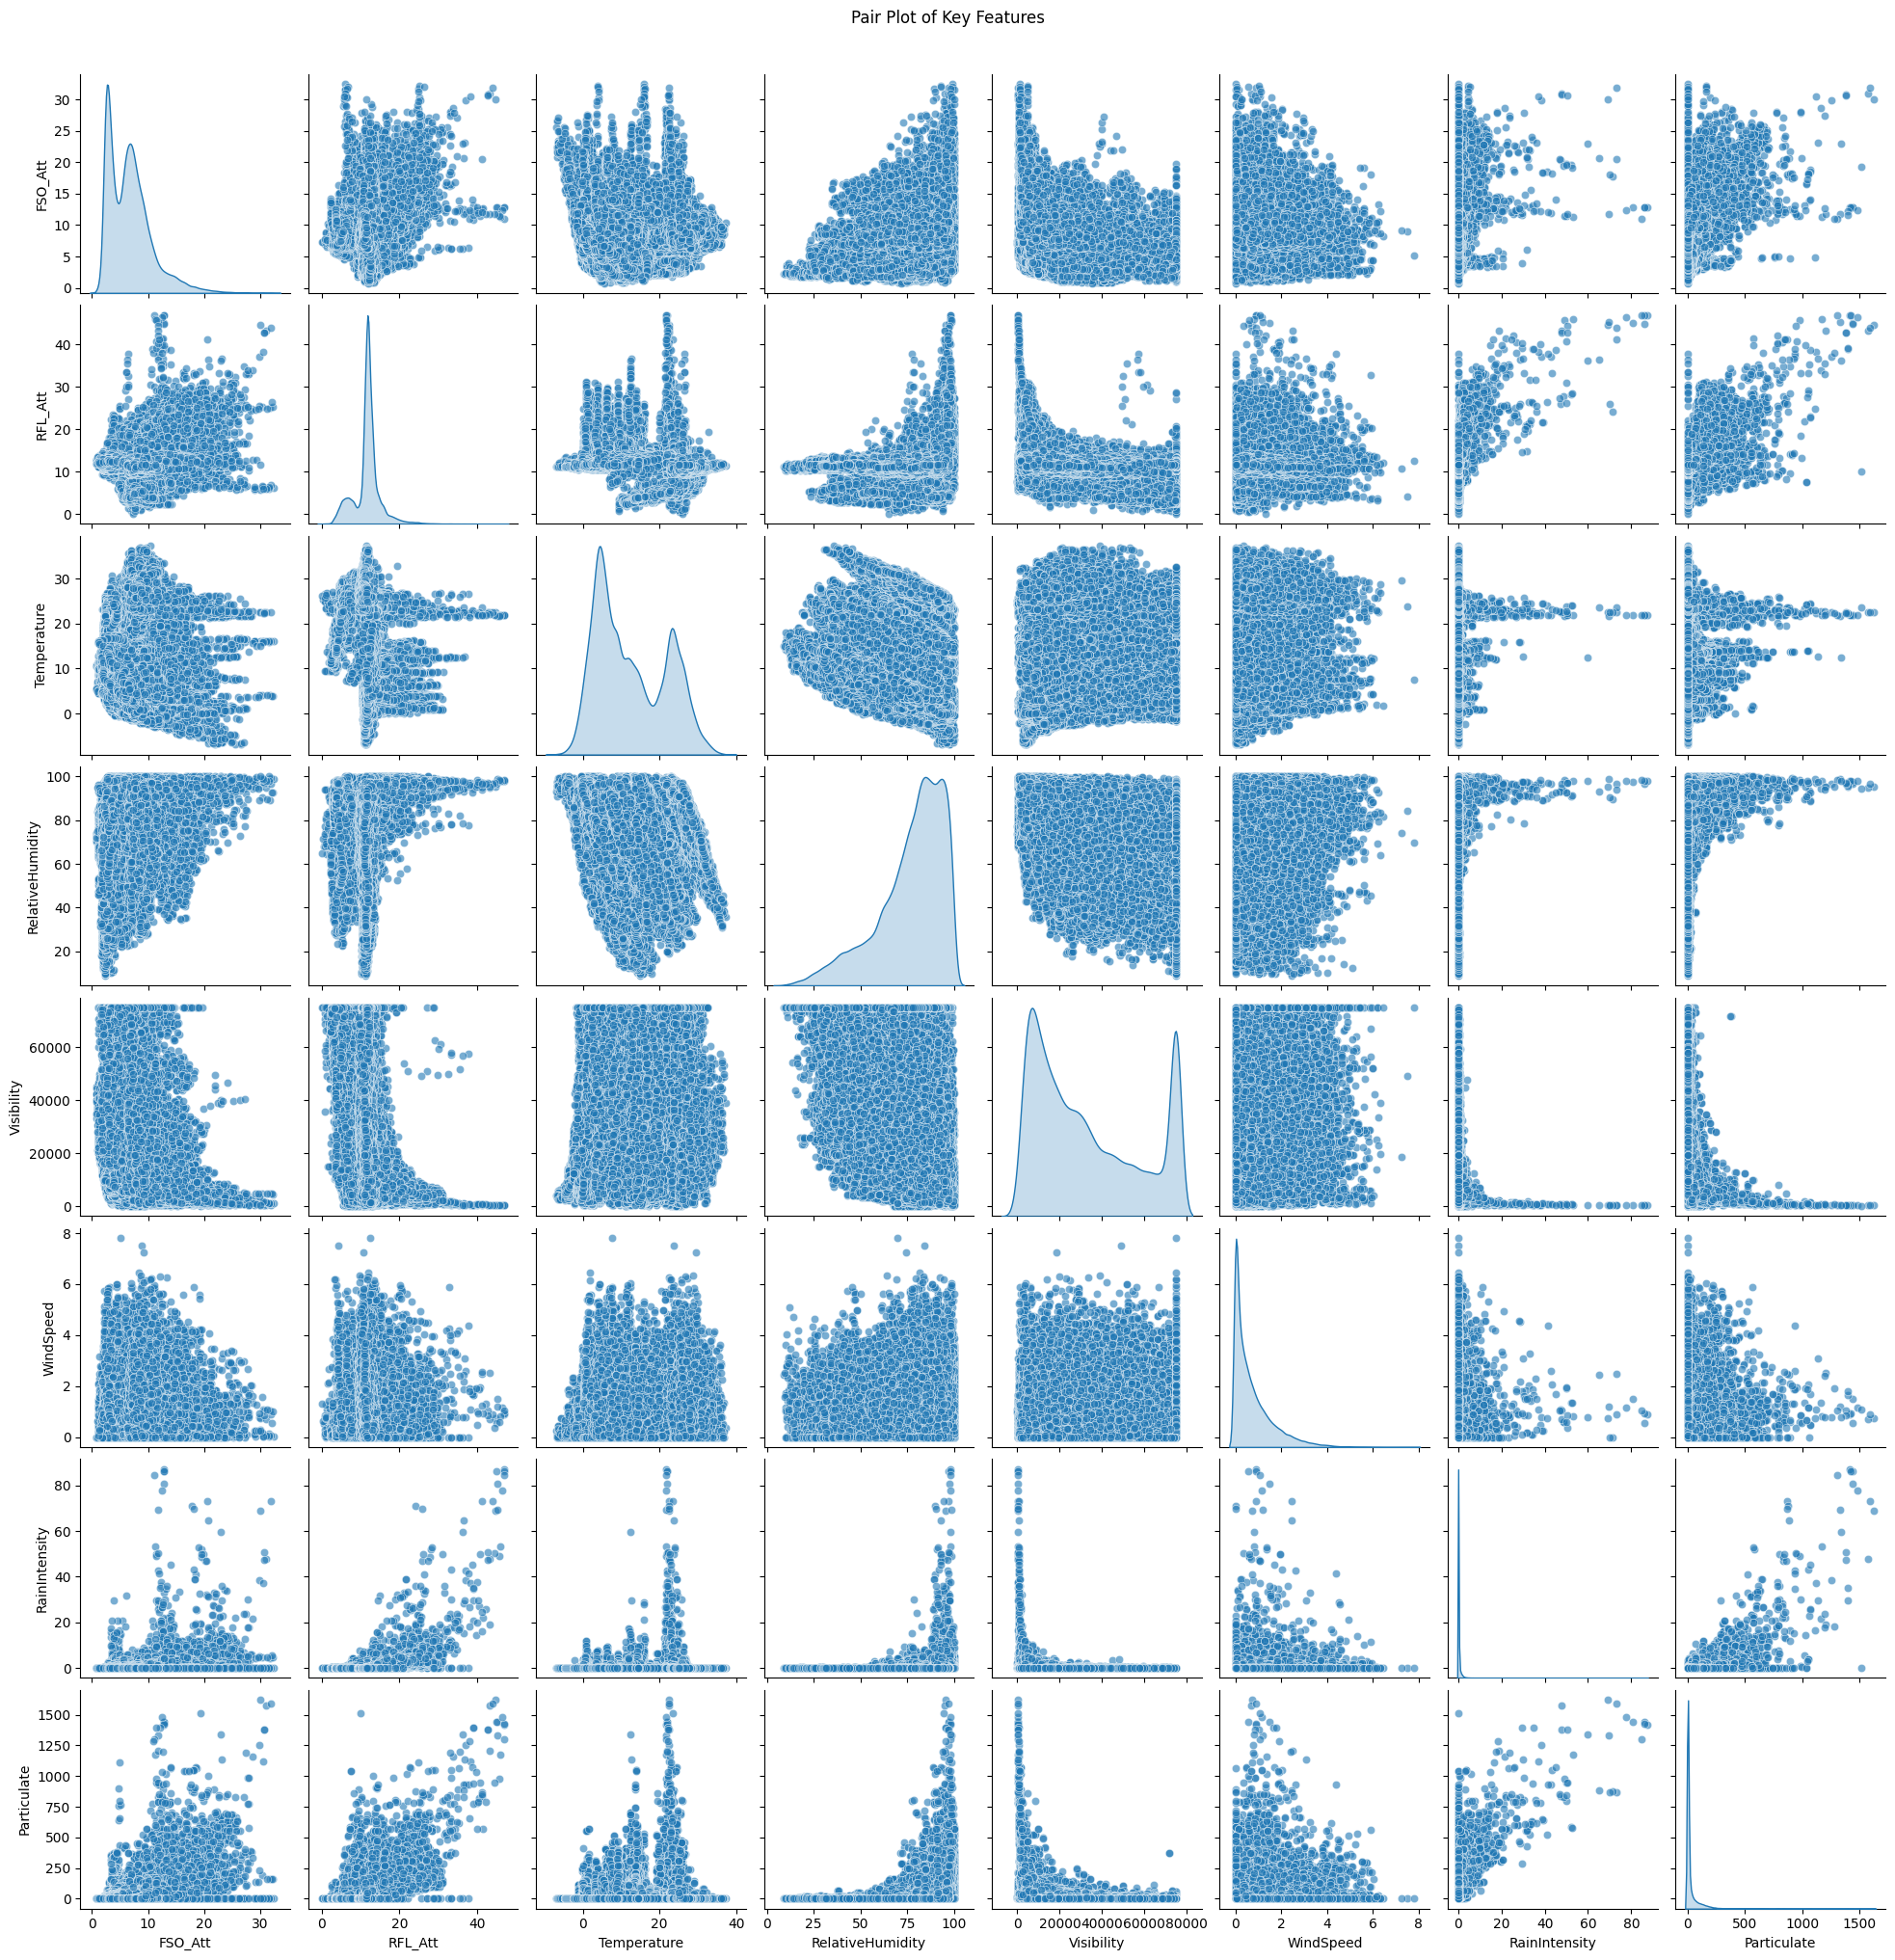

In [4]:
# select key variables
key_features = [
    'FSO_Att', 'RFL_Att', 
    'Temperature', 'RelativeHumidity',
    'Visibility', 'WindSpeed',
    'RainIntensity', 'Particulate'
]

# create pairplot
plt.figure(figsize=(12, 12))
sns.pairplot(
    data=original_data[key_features],
    diag_kind='kde',  
    plot_kws={'alpha': 0.6}, 
)
plt.suptitle('Pair Plot of Key Features', y=1.02)
plt.show()

In [5]:
processed_data = original_data.copy()

# Time: directly convert to category type
processed_data['Time'] = processed_data['Time'].astype('category')

# SYNOPCode: directly convert to category type
processed_data['SYNOPCode'] = processed_data['SYNOPCode'].astype('category')

# Frequency: convert to GHz unit
processed_data['Frequency'] = processed_data['Frequency'] / 1e9
print(processed_data.dtypes)


# prepare feature set (remove target variables)
feature_cols = [col for col in processed_data.columns 
               if col not in ['FSO_Att', 'RFL_Att']]

FSO_Att                   float64
RFL_Att                   float64
AbsoluteHumidity          float64
AbsoluteHumidityMax       float64
AbsoluteHumidityMin       float64
Distance                  float64
Frequency                 float64
Particulate               float64
ParticulateMax            float64
ParticulateMin            float64
RainIntensity             float64
RainIntensityMax          float64
RainIntensityMin          float64
RelativeHumidity          float64
SYNOPCode                category
Temperature               float64
TemperatureDifference     float64
TemperatureMax            float64
TemperatureMin            float64
Time                     category
Visibility                float64
VisibilityMax             float64
VisibilityMin             float64
WindDirection             float64
WindSpeed                 float64
WindSpeedMax              float64
WindSpeedMin              float64
dtype: object


In [6]:
# def split_data(df, feature_cols, test_size=0.2, random_state=42):
#     X = df[feature_cols]
#     y_rfl = df['RFL_Att']
#     y_fso = df['FSO_Att']
    
#     # 分层抽样，按 SYNOPCode 分层
#     X_train, X_test, y_rfl_train, y_rfl_test, y_fso_train, y_fso_test = train_test_split(
#         X, y_rfl, y_fso, test_size=test_size, random_state=random_state, stratify=df['SYNOPCode']
#     )
    
#     # 确保 SYNOPCode 是一维 Series
#     synop_train = df.loc[X_train.index, 'SYNOPCode'].reset_index(drop=True)
#     synop_test = df.loc[X_test.index, 'SYNOPCode'].reset_index(drop=True)
    
#     # 重建训练集和测试集
#     train_df = pd.concat([
#         X_train.reset_index(drop=True), 
#         y_rfl_train.rename('RFL_Att').reset_index(drop=True), 
#         y_fso_train.rename('FSO_Att').reset_index(drop=True)
#     ], axis=1)
    
#     test_df = pd.concat([
#         X_test.reset_index(drop=True), 
#         y_rfl_test.rename('RFL_Att').reset_index(drop=True), 
#         y_fso_test.rename('FSO_Att').reset_index(drop=True)
#     ], axis=1)
    
#     # 检查列名，确保没有重复
#     print("训练集列名：", train_df.columns.tolist())
#     print("测试集列名：", test_df.columns.tolist())
    
#     print("训练集样本数：", train_df.shape[0], "测试集样本数：", test_df.shape[0])
    
#     return train_df, test_df

In [ ]:
# train_df, test_df = split_data(processed_data, feature_cols)

训练集列名： ['AbsoluteHumidity', 'AbsoluteHumidityMax', 'AbsoluteHumidityMin', 'Distance', 'Frequency', 'Particulate', 'ParticulateMax', 'ParticulateMin', 'RainIntensity', 'RainIntensityMax', 'RainIntensityMin', 'RelativeHumidity', 'SYNOPCode', 'Temperature', 'TemperatureDifference', 'TemperatureMax', 'TemperatureMin', 'Time', 'Visibility', 'VisibilityMax', 'VisibilityMin', 'WindDirection', 'WindSpeed', 'WindSpeedMax', 'WindSpeedMin', 'RFL_Att', 'FSO_Att']
测试集列名： ['AbsoluteHumidity', 'AbsoluteHumidityMax', 'AbsoluteHumidityMin', 'Distance', 'Frequency', 'Particulate', 'ParticulateMax', 'ParticulateMin', 'RainIntensity', 'RainIntensityMax', 'RainIntensityMin', 'RelativeHumidity', 'SYNOPCode', 'Temperature', 'TemperatureDifference', 'TemperatureMax', 'TemperatureMin', 'Time', 'Visibility', 'VisibilityMax', 'VisibilityMin', 'WindDirection', 'WindSpeed', 'WindSpeedMax', 'WindSpeedMin', 'RFL_Att', 'FSO_Att']
训练集样本数： 73103 测试集样本数： 18276


In [7]:
def plot_feature_selection_results(results_df, title, divide_feature, save_path=None):
    """
    plot the feature selection process
    
    Parameters:
    -----------
    results_df : DataFrame
        the dataframe containing the feature selection results
    title : str
        the title of the image
    save_path : str, optional
        if provided, save the image to the specified path
    """
    fig, ax1 = plt.subplots(figsize=(15, 10))
    ax2 = ax1.twinx()

    # plot RMSE (blue line, left axis)
    line1 = ax1.plot(range(len(results_df)), 
                     results_df['oob_rmse'], 
                     color='blue', 
                     marker='o', 
                     label='RMSE')
    ax1.set_xlabel('Removed Features')
    ax1.set_ylabel('RMSE', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.grid(True, linestyle='--', alpha=0.7)

    # plot R² (red line, right axis)
    line2 = ax2.plot(range(len(results_df)), 
                     results_df['oob_r2'], 
                     color='red', 
                     marker='o', 
                     label='R²')
    ax2.set_ylabel('R² Score', color='red')
    ax2.tick_params(axis='y', labelcolor='red')


    ax1.set_xticks(range(len(results_df)))
    ax1.set_xticklabels(results_df['removed_feature'], rotation=90, ha='center')

    # find the position of Time and add a vertical line
    time_idx = results_df[results_df['removed_feature'] == divide_feature].index[0]
    ax1.axvline(x=time_idx - 0.5,  # subtract 0.5 from x value !!
                color='green', 
                linestyle='--',
                linewidth=2,
                alpha=0.8,
                label='Time Position')

    lines = line1 + line2 + [ax1.get_lines()[-1]]
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='upper left')

    plt.title(title)
    plt.subplots_adjust(bottom=0.3)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
    plt.show()





def load_and_plot_single_result(target_type, synop_code, divide_feature, method='method1'):
    """
    load and plot the feature selection results for a single SYNOP group
    
    Parameters:
    -----------
    target_type : str
        'RFL' 或 'FSO'
    synop_code : str or int
        the code of the SYNOP group
    """
    # result directory and file
    result_dir = f'results_{target_type.lower()}'
    result_file = f'synop_{synop_code}_results.pkl'
    
    # load results
    with open(os.path.join(result_dir, result_file), 'rb') as f:
        results_df = pickle.load(f)

    results_df = results_df.sort_index()
    # print(results_df)
    
    # create image title
    title = f'Feature Selection Results for SYNOP {synop_code} ({target_type})'
    
    save_path = os.path.join(result_dir, f'{target_type.lower()}_{method}_{synop_code}.png')
    
    plot_feature_selection_results(results_df, title, divide_feature, save_path)

    features_at_divide = results_df.loc[results_df['removed_feature'] == divide_feature, 'features'].values[0]

    
    return features_at_divide


In [8]:
def gene_final_X_y(important_features, target_type, synop_code=None):
    if synop_code is None:
        # actually, method2
        group_data = processed_data
    else:
        # actually, method1
        group_data = processed_data[processed_data['SYNOPCode'] == synop_code]
    
    X = group_data[important_features]
    y = group_data[target_type]
    return X, y


In [9]:
from sklearn.metrics import make_scorer
def tune_random_forest(X, y, param_grid=None, cv=5, verbose=True):
    """
    tune the hyperparameters of the random forest model
    
    Parameters:
    -----------
    X : feature data
    y : target variable
    param_grid : hyperparameter grid, if None, use the default grid
    cv : number of cross-validation folds
    verbose : whether to print detailed information
    
    Returns:
    --------
    dict : a dictionary containing the best model and performance metrics
    """
    # if param_grid is None, use the default grid
    if param_grid is None:
        param_grid = {
            'n_estimators': [100, 150],
            'max_depth': [None, 10, 20]
        }
    
    if verbose:
        print("Start tuning...")
        print(f"Dataset size: {X.shape}")
        print("Parameter grid:", param_grid)
        print("\n" + "-"*80)
        print(f"{'n_estimators':>12} | {'max_depth':>9} | {'OOB Score':>9} | {'OOB R²':>9} | {'OOB RMSE':>9}")
        print("-"*80)

    results = []


    # nested loop to iterate through all parameter combinations
    for n_trees in param_grid['n_estimators']:
        for max_depth in param_grid['max_depth']:
            # train model
            rf = RandomForestRegressor(
                n_estimators=n_trees,
                max_depth=max_depth,
                random_state=42,
                oob_score=True,
                n_jobs=-1
            )
            rf.fit(X, y)
            
            # get OOB prediction and scores
            oob_score = rf.oob_score_
            y_pred = rf.oob_prediction_
            r2 = r2_score(y, y_pred)
            rmse = np.sqrt(mean_squared_error(y, y_pred))
            
            results.append({
                'n_estimators': n_trees,
                'max_depth': max_depth,
                'oob_score': oob_score,
                'r2': r2,
                'rmse': rmse,
                'model': rf
            })
            
            if verbose:
                print(f"{n_trees:>12} | {str(max_depth):>9} | {oob_score:>9.6f} | {r2:>9.6f} | {rmse:>9.6f}")
    

    best_result = max(results, key=lambda x: x['oob_score'])

    if verbose:
        print("\nBest result:")
        print(f"Best parameters: n_estimators={best_result['n_estimators']}, max_depth={best_result['max_depth']}")
        print(f"Best OOB Score: {best_result['oob_score']:.6f}")
        print(f"Best OOB R² Score: {best_result['r2']:.6f}")
        print(f"Best OOB RMSE: {best_result['rmse']:.6f}")
    
    return {
        'best_params': {
            'n_estimators': best_result['n_estimators'],
            'max_depth': best_result['max_depth']
        },
        'best_oob_score': best_result['oob_score'],
        'final_model': best_result['model'],
        'oob_r2_score': best_result['r2'],
        'oob_rmse': best_result['rmse'],
        'results': results
    }



In [10]:
important_features_rfl_sc7 = ['AbsoluteHumidity',
 'AbsoluteHumidityMax',
 'Frequency',
 'ParticulateMin',
 'RainIntensity',
 'RainIntensityMax',
 'RainIntensityMin',
 'RelativeHumidity',
 'Temperature',
 'TemperatureDifference',
 'Time',
 'VisibilityMin',
 'WindSpeedMax']

important_features_fso_sc7_wo = ['Particulate',
                        'ParticulateMax',
                        'ParticulateMin',
                        'RelativeHumidity',
                        'Temperature',
                        'TemperatureDifference',
                        'TemperatureMax',
                        'TemperatureMin',
                        'Visibility',
                        'WindSpeedMax']

important_features_fso_sc7 = ['Particulate',
                        'ParticulateMax',
                        'ParticulateMin',
                        'RelativeHumidity',
                        'Temperature',
                        'TemperatureDifference',
                        'TemperatureMax',
                        'TemperatureMin',
                        'Visibility',
                        'WindSpeedMax',
                        'RFL_Att']


In [101]:
train_idx, test_idx = train_test_split( processed_data[processed_data['SYNOPCode'] == 7].index, test_size=0.2, random_state=42)

In [102]:
#train test split
X_rfl_method2, y_rfl_method2 = gene_final_X_y(important_features_rfl_sc7, 'RFL_Att', synop_code=7)
x_train_rfl,y_train_rfl = X_rfl_method2.loc[train_idx], y_rfl_method2.loc[train_idx]
x_test_rfl,y_test_rfl = X_rfl_method2.loc[test_idx], y_rfl_method2.loc[test_idx]

Start tuning...
Dataset size: (335, 13)
Parameter grid: {'n_estimators': [100, 150], 'max_depth': [None, 10, 20]}

--------------------------------------------------------------------------------
n_estimators | max_depth | OOB Score |    OOB R² |  OOB RMSE
--------------------------------------------------------------------------------
         100 |      None |  0.954162 |  0.954162 |  0.336388
         100 |        10 |  0.953924 |  0.953924 |  0.337263
         100 |        20 |  0.954162 |  0.954162 |  0.336388
         150 |      None |  0.955848 |  0.955848 |  0.330146
         150 |        10 |  0.955789 |  0.955789 |  0.330367
         150 |        20 |  0.955848 |  0.955848 |  0.330146

Best result:
Best parameters: n_estimators=150, max_depth=None
Best OOB Score: 0.955848
Best OOB R² Score: 0.955848
Best OOB RMSE: 0.330146
Model training time: 1.02 seconds


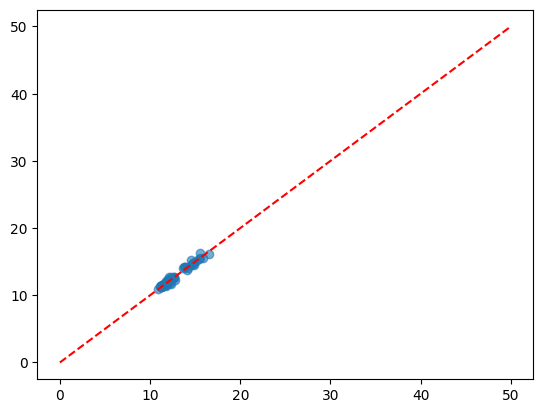

In [103]:
start_time = time.time()

rfl_method2_tune = tune_random_forest(
    x_train_rfl, 
    y_train_rfl,
    cv=5,
    verbose=True
)

rfl_method2_best_model = rfl_method2_tune['final_model']
end_time = time.time()
print(f"Model training time: {end_time - start_time:.2f} seconds")
# predict on test set
y_pred_rfl = rfl_method2_best_model.predict(x_test_rfl)
plt.scatter(y_test_rfl, y_pred_rfl, alpha=0.6)
plt.plot([0, 50], [0, 50], color='red', linestyle='--')

In [104]:
#train test split
X_fso_method2, y_fso_method2 = gene_final_X_y(important_features_fso_sc7, 'FSO_Att', synop_code=7)
x_train_fso,y_train_fso = X_fso_method2.loc[train_idx], y_fso_method2.loc[train_idx]
x_test_fso,y_test_fso = X_fso_method2.loc[test_idx], y_fso_method2.loc[test_idx]

Start tuning...
Dataset size: (335, 11)
Parameter grid: {'n_estimators': [100, 150], 'max_depth': [None, 10, 20]}

--------------------------------------------------------------------------------
n_estimators | max_depth | OOB Score |    OOB R² |  OOB RMSE
--------------------------------------------------------------------------------
         100 |      None |  0.948667 |  0.948667 |  1.204960
         100 |        10 |  0.948206 |  0.948206 |  1.210350
         100 |        20 |  0.948713 |  0.948713 |  1.204415
         150 |      None |  0.948415 |  0.948415 |  1.207914
         150 |        10 |  0.948021 |  0.948021 |  1.212517
         150 |        20 |  0.948449 |  0.948449 |  1.207512

Best result:
Best parameters: n_estimators=100, max_depth=20
Best OOB Score: 0.948713
Best OOB R² Score: 0.948713
Best OOB RMSE: 1.204415
Model training time: 1.07 seconds


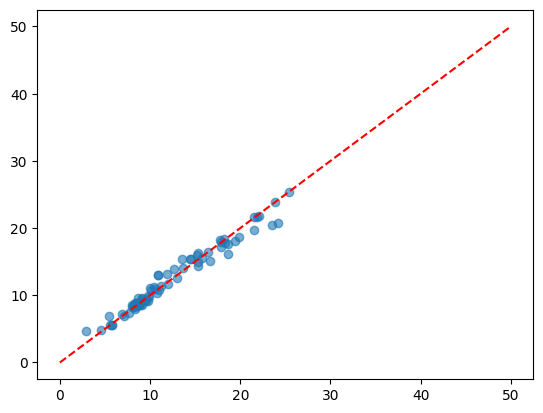

In [107]:
start_time = time.time()

fso_method2_tune = tune_random_forest(
    x_train_fso, 
    y_train_fso,
    cv=5,
    verbose=True
)

fso_method2_best_model = fso_method2_tune['final_model']
end_time = time.time()
print(f"Model training time: {end_time - start_time:.2f} seconds")
# predict on test set
y_pred_fso = fso_method2_best_model.predict(x_test_fso)
plt.scatter(y_test_fso, y_pred_fso, alpha=0.6)
plt.plot([0, 50], [0, 50], color='red', linestyle='--')

In [108]:
#train test split
X_fso_method2_wo, y_fso_method2_wo = gene_final_X_y(important_features_fso_sc7_wo, 'FSO_Att', synop_code=7)
x_train_fso_wo,y_train_fso_wo = X_fso_method2_wo.loc[train_idx], y_fso_method2_wo.loc[train_idx]
x_test_fso_wo,y_test_fso_wo = X_fso_method2_wo.loc[test_idx], y_fso_method2_wo.loc[test_idx]

Start tuning...
Dataset size: (335, 10)
Parameter grid: {'n_estimators': [100, 150], 'max_depth': [None, 10, 20]}

--------------------------------------------------------------------------------
n_estimators | max_depth | OOB Score |    OOB R² |  OOB RMSE
--------------------------------------------------------------------------------
         100 |      None |  0.948608 |  0.948608 |  1.205651
         100 |        10 |  0.948741 |  0.948741 |  1.204084
         100 |        20 |  0.948621 |  0.948621 |  1.205490
         150 |      None |  0.949183 |  0.949183 |  1.198888
         150 |        10 |  0.949471 |  0.949471 |  1.195485
         150 |        20 |  0.949164 |  0.949164 |  1.199110

Best result:
Best parameters: n_estimators=150, max_depth=10
Best OOB Score: 0.949471
Best OOB R² Score: 0.949471
Best OOB RMSE: 1.195485
Model training time: 0.93 seconds


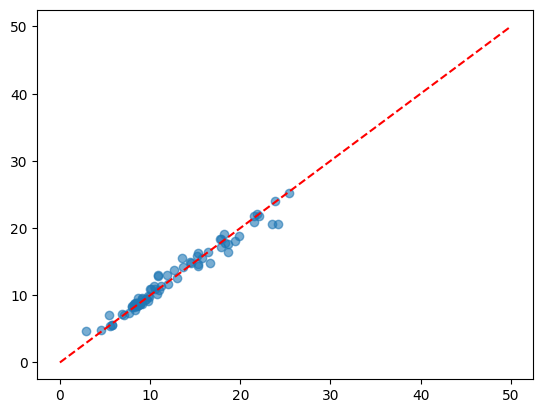

In [110]:
start_time = time.time()

fso_method2_tune_wo = tune_random_forest(
    x_train_fso_wo, 
    y_train_fso_wo,
    cv=5,
    verbose=True
)

fso_method2_best_model_wo = fso_method2_tune_wo['final_model']
end_time = time.time()
print(f"Model training time: {end_time - start_time:.2f} seconds")
# predict on test set
y_pred_fso_wo = fso_method2_best_model_wo.predict(x_test_fso_wo)
plt.scatter(y_test_fso_wo, y_pred_fso_wo, alpha=0.6)
plt.plot([0, 50], [0, 50], color='red', linestyle='--')

Text(0.5, 1.0, 'PCC using RFL: 0.8247')

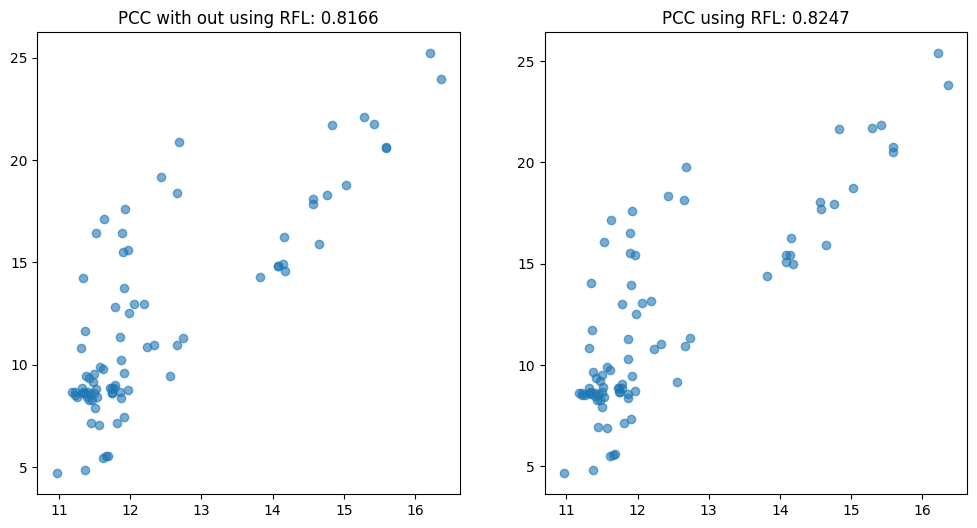

In [113]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)

plt.scatter(y_pred_rfl, y_pred_fso_wo, alpha=0.6)
pcc = np.corrcoef(y_pred_rfl, y_pred_fso_wo)[0, 1]
plt.title(f"PCC with out using RFL: {pcc:.4f}")

plt.subplot(1, 2, 2)

plt.scatter(y_pred_rfl, y_pred_fso, alpha=0.6)
pcc = np.corrcoef(y_pred_rfl, y_pred_fso)[0, 1]
plt.title(f"PCC using RFL: {pcc:.4f}")

In [11]:
important_features_rfl_method2 = ['AbsoluteHumidity',
 'Distance',
 'Frequency',
 'ParticulateMax',
 'RainIntensity',
 'RainIntensityMax',
 'RainIntensityMin',
 'RelativeHumidity',
 'SYNOPCode',
 'Temperature',
 'TemperatureMax',
 'Visibility']

In [12]:

train_idx, test_idx = train_test_split(processed_data.index, test_size=0.2, random_state=42)

In [13]:
#train test split
X_rfl_method2, y_rfl_method2 = gene_final_X_y(important_features_rfl_method2, 'RFL_Att')

x_train_rfl,y_train_rfl = X_rfl_method2.loc[train_idx], y_rfl_method2.loc[train_idx]
x_test_rfl,y_test_rfl = X_rfl_method2.loc[test_idx], y_rfl_method2.loc[test_idx]

In [14]:
start_time = time.time()

rfl_method2_tune = tune_random_forest(
    x_train_rfl, 
    y_train_rfl,
    cv=5,
    verbose=True
)

rfl_method2_best_model = rfl_method2_tune['final_model']
end_time = time.time()
print(f"Model training time: {end_time - start_time:.2f} seconds")

Start tuning...
Dataset size: (73103, 12)
Parameter grid: {'n_estimators': [100, 150], 'max_depth': [None, 10, 20]}

--------------------------------------------------------------------------------
n_estimators | max_depth | OOB Score |    OOB R² |  OOB RMSE
--------------------------------------------------------------------------------
         100 |      None |  0.972084 |  0.972084 |  0.574440
         100 |        10 |  0.958478 |  0.958478 |  0.700575
         100 |        20 |  0.971959 |  0.971959 |  0.575728
         150 |      None |  0.972465 |  0.972465 |  0.570505
         150 |        10 |  0.958752 |  0.958752 |  0.698262
         150 |        20 |  0.972465 |  0.972465 |  0.570511

Best result:
Best parameters: n_estimators=150, max_depth=None
Best OOB Score: 0.972465
Best OOB R² Score: 0.972465
Best OOB RMSE: 0.570505
Model training time: 51.57 seconds


In [15]:
# predict on test set
y_pred_rfl = rfl_method2_best_model.predict(x_test_rfl)

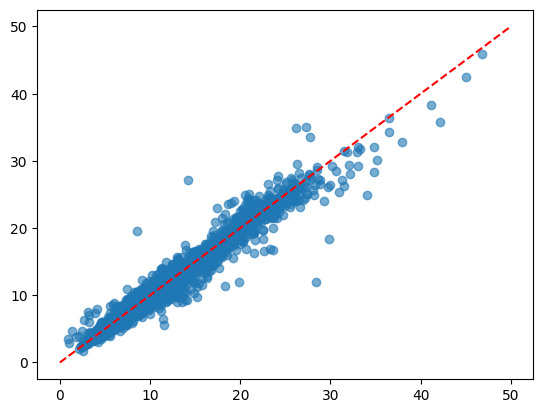

In [16]:
plt.scatter(y_test_rfl, y_pred_rfl, alpha=0.6)
plt.plot([0, 50], [0, 50], color='red', linestyle='--')

In [17]:
important_features_fso_method2_without_rfl = ['AbsoluteHumidity',
 'Distance',
 'Particulate',
 'ParticulateMax',
 'ParticulateMin',
 'RelativeHumidity',
 'Temperature',
 'TemperatureDifference',
 'TemperatureMin',
 'Time',
 'Visibility',
 'VisibilityMin']

In [18]:
#train test split
X_fso_method2, y_fso_method2 = gene_final_X_y(important_features_fso_method2_without_rfl, 'FSO_Att')

x_train_fso_wo,y_train_fso_wo = X_fso_method2.loc[train_idx], y_fso_method2.loc[train_idx]
x_test_fso_wo,y_test_fso_wo = X_fso_method2.loc[test_idx], y_fso_method2.loc[test_idx]

In [19]:
start_time = time.time()

fso_method2_tune_without_rfl = tune_random_forest(
    x_train_fso_wo, 
    y_train_fso_wo,
    cv=5,
    verbose=True
)

fso_method2_best_model_without_rfl = fso_method2_tune_without_rfl['final_model']
end_time = time.time()
print(f"Model training time: {end_time - start_time:.2f} seconds")

Start tuning...
Dataset size: (73103, 12)
Parameter grid: {'n_estimators': [100, 150], 'max_depth': [None, 10, 20]}

--------------------------------------------------------------------------------
n_estimators | max_depth | OOB Score |    OOB R² |  OOB RMSE
--------------------------------------------------------------------------------
         100 |      None |  0.957580 |  0.957580 |  0.805578
         100 |        10 |  0.904450 |  0.904450 |  1.209031
         100 |        20 |  0.956097 |  0.956097 |  0.819536
         150 |      None |  0.958171 |  0.958171 |  0.799952
         150 |        10 |  0.904530 |  0.904530 |  1.208527
         150 |        20 |  0.956659 |  0.956659 |  0.814279

Best result:
Best parameters: n_estimators=150, max_depth=None
Best OOB Score: 0.958171
Best OOB R² Score: 0.958171
Best OOB RMSE: 0.799952
Model training time: 58.29 seconds


In [20]:
y_pred_fso_without_rfl = fso_method2_best_model_without_rfl.predict(x_test_fso_wo)

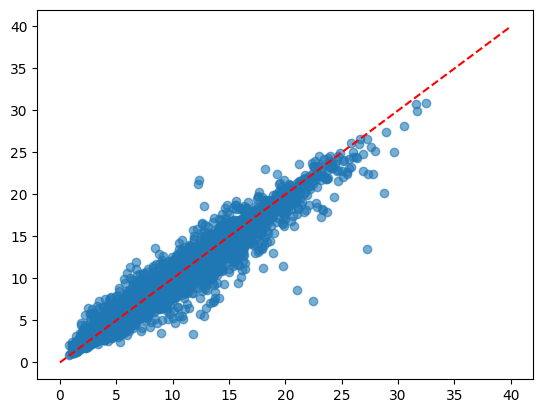

In [21]:
plt.scatter(y_test_fso_wo, y_pred_fso_without_rfl, alpha=0.6)
plt.plot([0, 40], [0, 40], color='red', linestyle='--')

In [22]:
important_features_fso_method2 = ['AbsoluteHumidity',
 'Distance',
 'Particulate',
 'ParticulateMax',
 'ParticulateMin',
 'RelativeHumidity',
 'Temperature',
 'TemperatureDifference',
 'TemperatureMin',
 'Time',
 'Visibility',
 'VisibilityMin',
 'RFL_Att']

In [23]:
#train test split
X_fso_method2, y_fso_method2 = gene_final_X_y(important_features_fso_method2, 'FSO_Att')

x_train_fso,y_train_fso = X_fso_method2.loc[train_idx], y_fso_method2.loc[train_idx]
x_test_fso,y_test_fso = X_fso_method2.loc[test_idx], y_fso_method2.loc[test_idx]

In [24]:
start_time = time.time()

fso_method2_tune = tune_random_forest(
    x_train_fso, 
    y_train_fso,
    cv=5,
    verbose=True
)

fso_method2_best_model = fso_method2_tune['final_model']
end_time = time.time()
print(f"Model training time: {end_time - start_time:.2f} seconds")

Start tuning...
Dataset size: (73103, 13)
Parameter grid: {'n_estimators': [100, 150], 'max_depth': [None, 10, 20]}

--------------------------------------------------------------------------------
n_estimators | max_depth | OOB Score |    OOB R² |  OOB RMSE
--------------------------------------------------------------------------------
         100 |      None |  0.954379 |  0.954379 |  0.835420
         100 |        10 |  0.899122 |  0.899122 |  1.242282
         100 |        20 |  0.952505 |  0.952505 |  0.852406
         150 |      None |  0.954883 |  0.954883 |  0.830796
         150 |        10 |  0.898934 |  0.898934 |  1.243441
         150 |        20 |  0.952982 |  0.952982 |  0.848112

Best result:
Best parameters: n_estimators=150, max_depth=None
Best OOB Score: 0.954883
Best OOB R² Score: 0.954883
Best OOB RMSE: 0.830796
Model training time: 71.10 seconds


In [25]:
y_pred_fso = fso_method2_best_model.predict(x_test_fso)

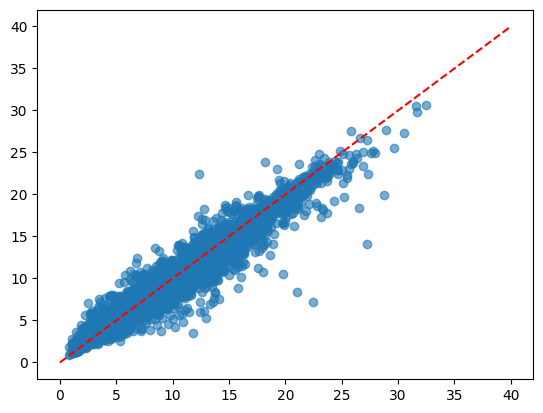

In [26]:
plt.scatter(y_test_fso, y_pred_fso, alpha=0.6)
plt.plot([0, 40], [0, 40], color='red', linestyle='--')

Pearson correlation coefficient: 0.088131


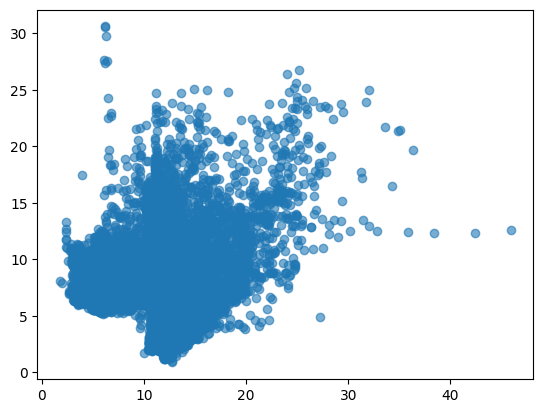

In [27]:
plt.scatter(y_pred_rfl, y_pred_fso, alpha=0.6)
#pcc
pcc = np.corrcoef(y_pred_rfl, y_pred_fso)[0, 1]
print(f"Pearson correlation coefficient: {pcc:.6f}")

Pearson correlation coefficient: 0.083863


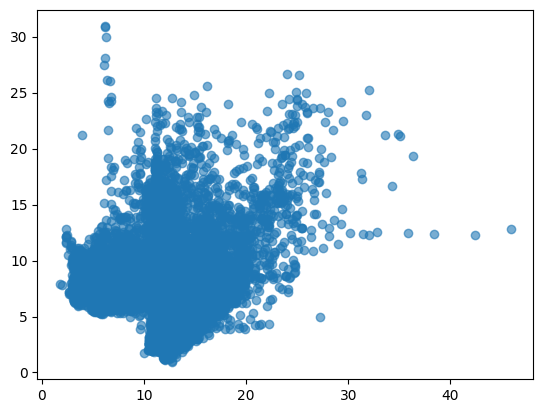

In [28]:

plt.scatter(y_pred_rfl, y_pred_fso_without_rfl, alpha=0.6)
#pcc
pcc = np.corrcoef(y_pred_rfl, y_pred_fso_without_rfl)[0, 1]
print(f"Pearson correlation coefficient: {pcc:.6f}")

Pearson correlation coefficient: 0.088429


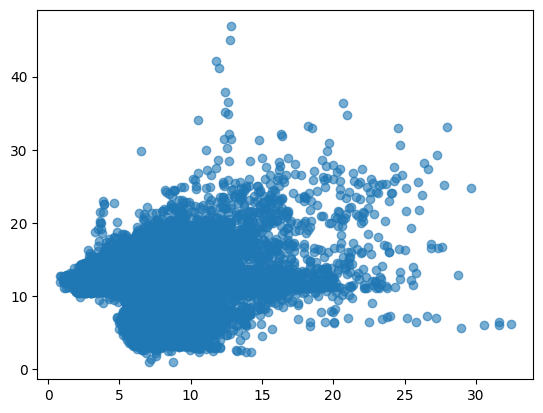

In [29]:

plt.scatter(y_test_fso_wo, y_test_rfl, alpha=0.6)
#pcc
pcc = np.corrcoef(y_test_fso_wo, y_test_rfl)[0, 1]
print(f"Pearson correlation coefficient: {pcc:.6f}")

In [89]:
#train test split
_, y_rfl_7 = gene_final_X_y(important_features_rfl_method2, 'RFL_Att', synop_code=7)
_, y_fso_7 = gene_final_X_y(important_features_rfl_method2, 'FSO_Att', synop_code=7)

Pearson correlation coefficient: 0.804480


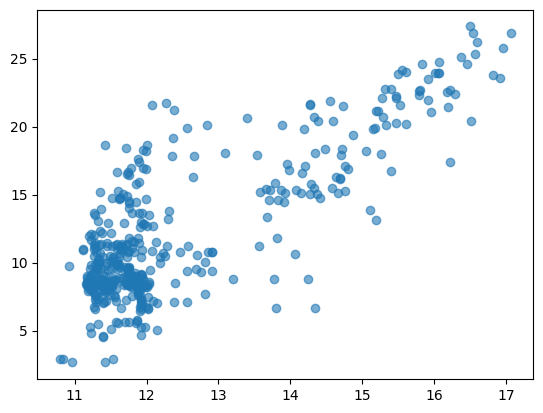

In [90]:
plt.scatter(y_rfl_7, y_fso_7, alpha=0.6)
#pcc
pcc = np.corrcoef(y_rfl_7, y_fso_7)[0, 1]
print(f"Pearson correlation coefficient: {pcc:.6f}")

In [32]:
_,synop_code = gene_final_X_y(important_features_rfl_method2, 'SYNOPCode')



In [34]:
synop_code_test = synop_code.loc[test_idx]

In [49]:
y_test_fso_wo

23811     3.555870
33249     4.029149
31945     5.697896
3431     11.731163
66292     4.094981
           ...    
89409     7.105075
25495     2.729125
76781     6.399596
83544     3.094887
59214     4.991111
Name: FSO_Att, Length: 18276, dtype: float64

In [50]:
y_test_fso

23811     3.555870
33249     4.029149
31945     5.697896
3431     11.731163
66292     4.094981
           ...    
89409     7.105075
25495     2.729125
76781     6.399596
83544     3.094887
59214     4.991111
Name: FSO_Att, Length: 18276, dtype: float64

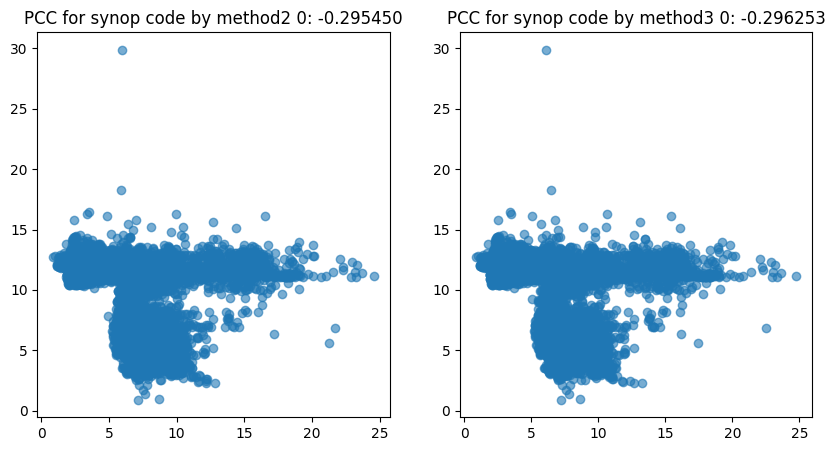

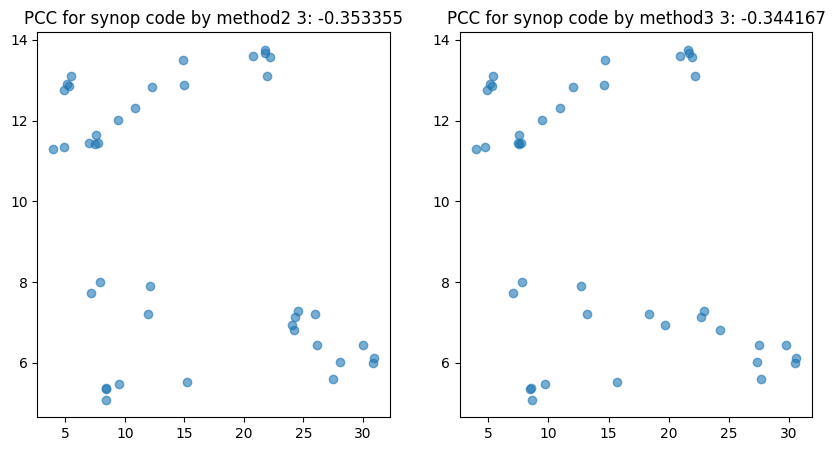

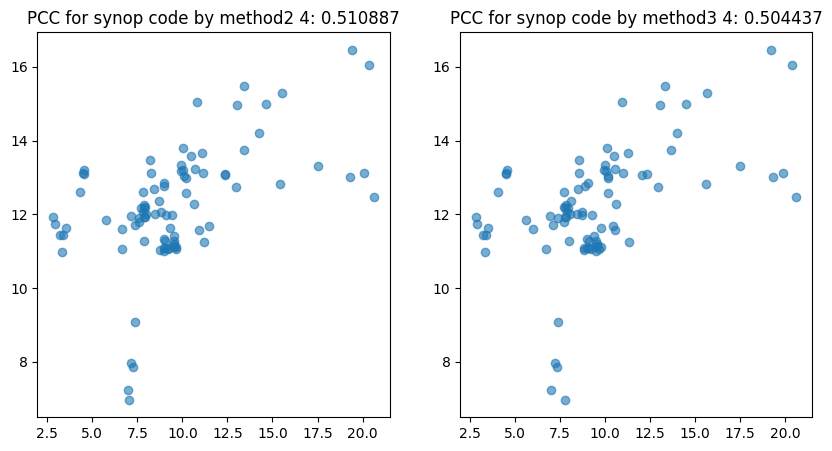

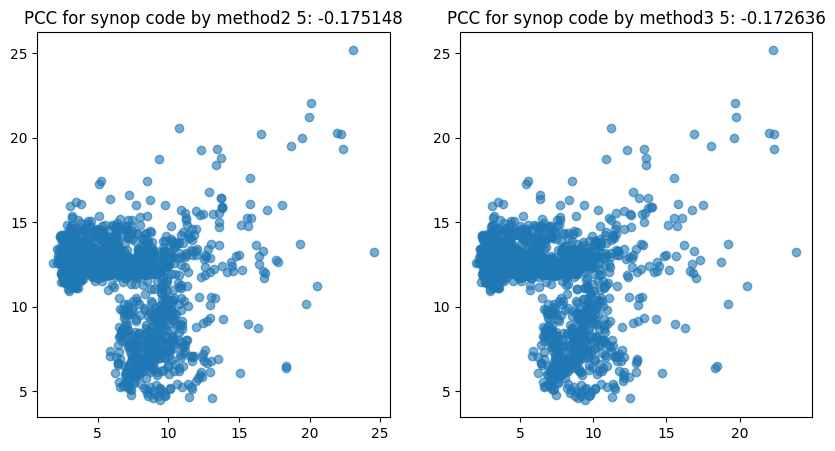

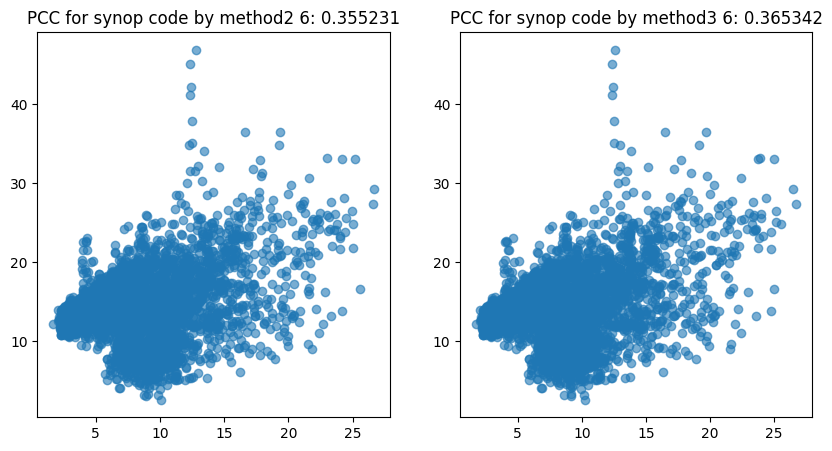

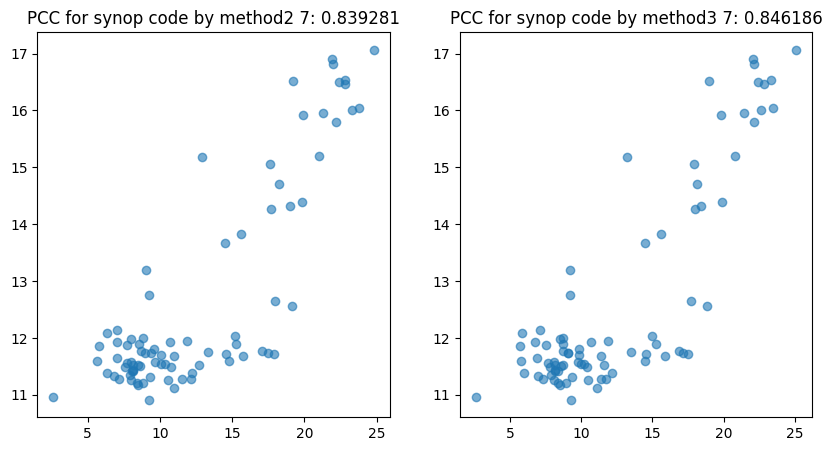

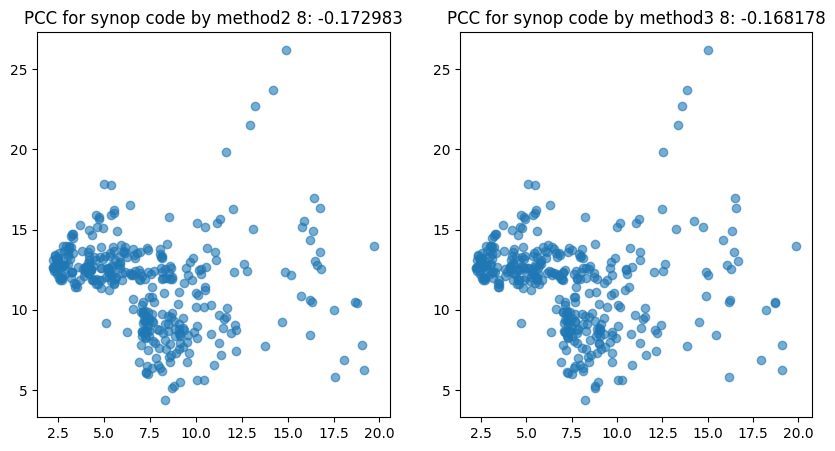

In [56]:
data = []
for sy in [0,3,4,5,6,7,8]:
    data_sy = []
    data_sy.append(sy)
    idx = synop_code_test==sy
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.scatter(y_pred_fso_without_rfl[idx], y_test_rfl[idx], alpha=0.6)
    #pcc
    pcc = np.corrcoef(y_pred_fso_without_rfl[idx], y_test_rfl[idx])[0, 1]
    plt.title(f"PCC for synop code by method2 {sy}: {pcc:.6f}")
    data_sy.append(float(pcc))
    plt.subplot(122)
    plt.scatter(y_pred_fso[idx], y_test_rfl[idx], alpha=0.6)
    #pcc
    pcc = np.corrcoef(y_pred_fso[idx], y_test_rfl[idx])[0, 1]
    data_sy.append(float(pcc))
    plt.title(f"PCC for synop code by method3 {sy}: {pcc:.6f}")
    plt.show()
    data.append(data_sy)

In [59]:
pd.DataFrame(data,columns=['synop_code','PCC_method2','PCC_method3'])

synop_code  PCC_method2  PCC_method3
0           0    -0.295450    -0.296253
1           3    -0.353355    -0.344167
2           4     0.510887     0.504437
3           5    -0.175148    -0.172636
4           6     0.355231     0.365342
5           7     0.839281     0.846186
6           8    -0.172983    -0.168178

In [60]:
from sklearn.metrics import mean_squared_error

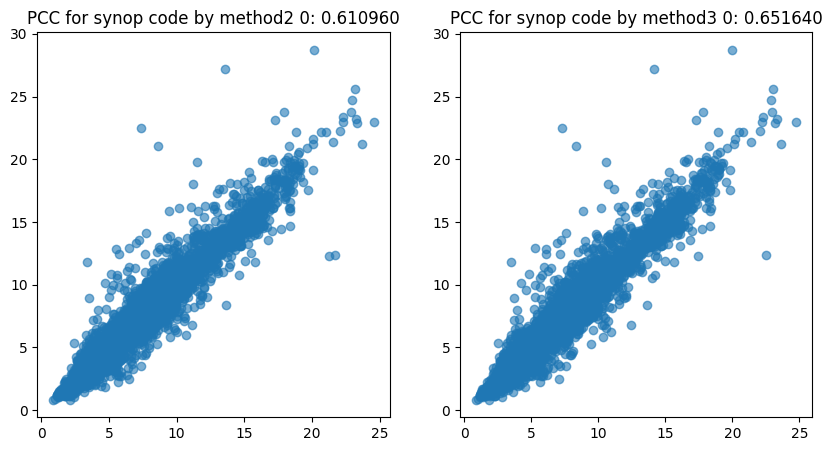

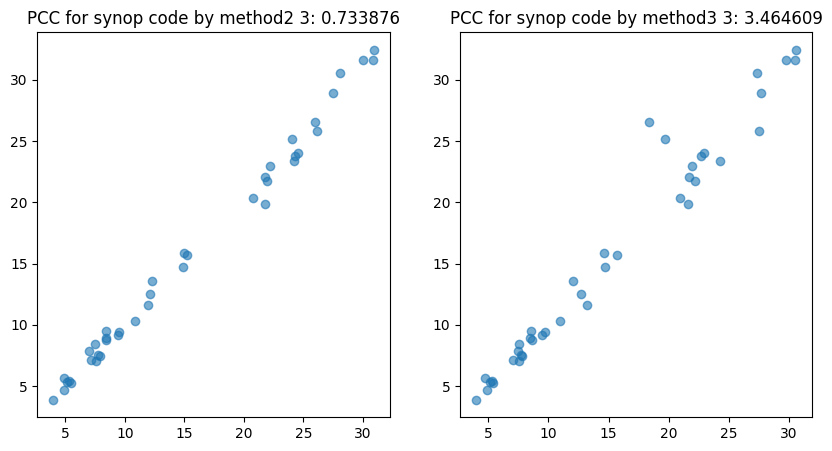

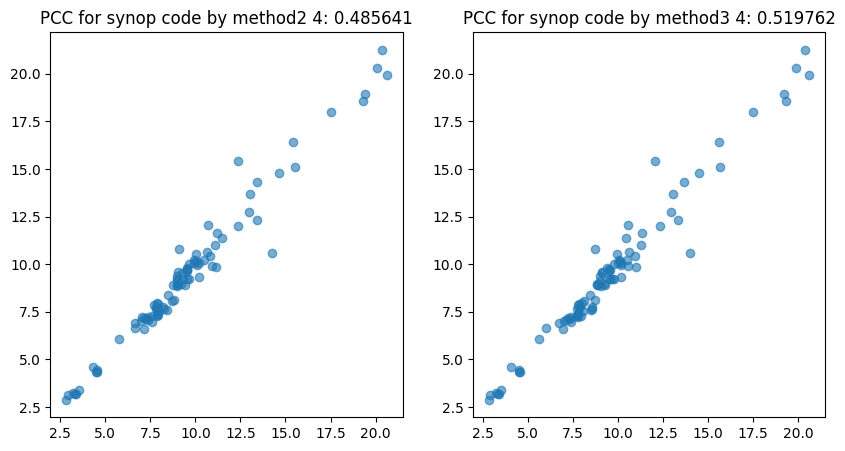

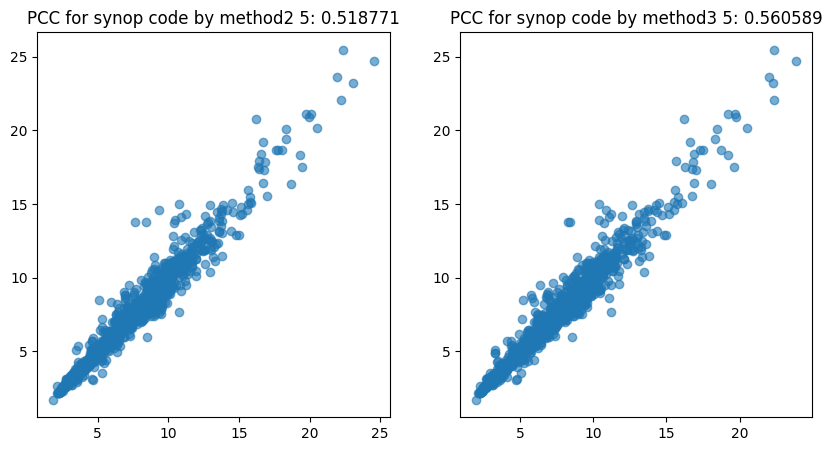

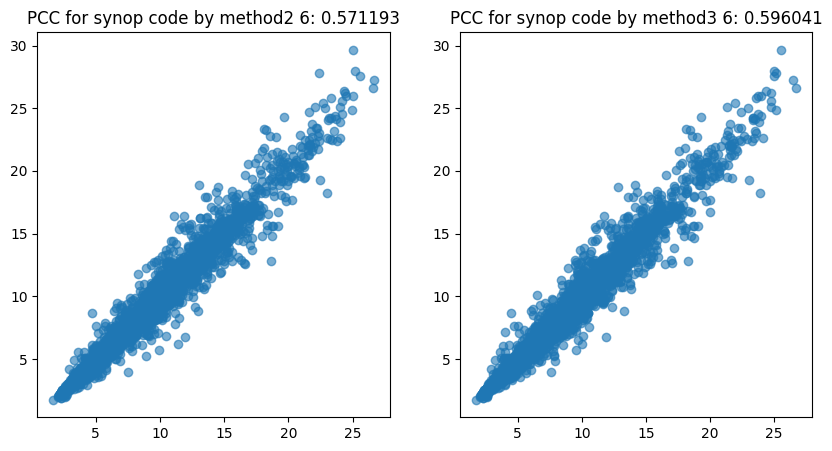

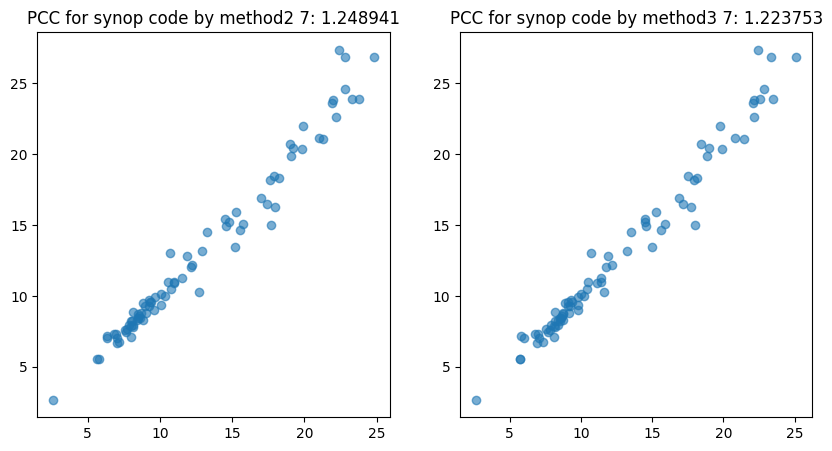

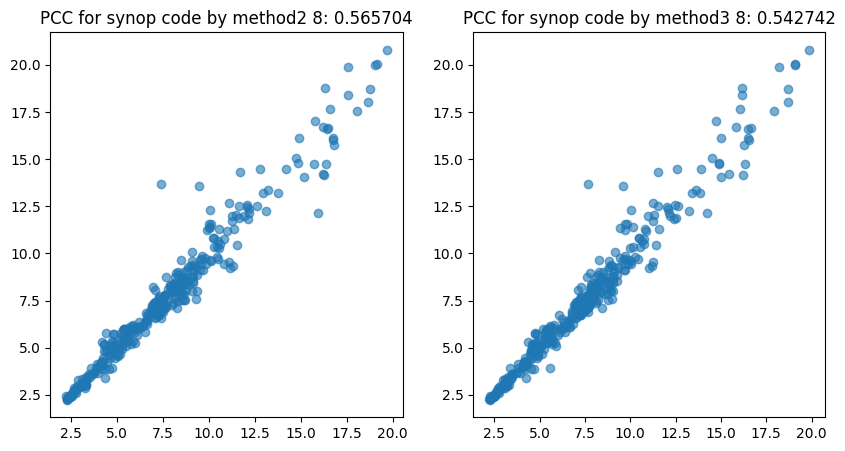

In [63]:
data = []
for sy in [0,3,4,5,6,7,8]:
    data_sy = []
    data_sy.append(sy)
    idx = synop_code_test==sy
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.scatter(y_pred_fso_without_rfl[idx], y_test_fso[idx], alpha=0.6)
    #pcc
    mse = mean_squared_error(y_pred_fso_without_rfl[idx], y_test_fso[idx])
    rmse = np.sqrt(mse)
    plt.title(f"PCC for synop code by method2 {sy}: {mse:.6f}")
    data_sy.append(float(mse))
    data_sy.append(float(rmse))
    plt.subplot(122)
    plt.scatter(y_pred_fso[idx], y_test_fso[idx], alpha=0.6)
    #pcc
    mse = mean_squared_error(y_pred_fso[idx], y_test_fso[idx])
    rmse = np.sqrt(mse)
    data_sy.append(float(mse))
    data_sy.append(float(rmse))
    plt.title(f"PCC for synop code by method3 {sy}: {mse:.6f}")
    plt.show()
    data.append(data_sy)

In [64]:
pd.DataFrame(data,columns=['synop_code','MSE_method2','RMSE_method2','MSE_method3','RMSE_method3'])

synop_code  MSE_method2  RMSE_method2  MSE_method3  RMSE_method3
0           0     0.610960      0.781639     0.651640      0.807242
1           3     0.733876      0.856666     3.464609      1.861346
2           4     0.485641      0.696880     0.519762      0.720945
3           5     0.518771      0.720257     0.560589      0.748725
4           6     0.571193      0.755773     0.596041      0.772037
5           7     1.248941      1.117560     1.223753      1.106234
6           8     0.565704      0.752133     0.542742      0.736710

In [ ]:
plt.scatter(y_test_fso_wo, y_test_rfl, alpha=0.6)
#pcc
pcc = np.corrcoef(y_test_fso_wo, y_test_rfl)[0, 1]
print(f"Pearson correlation coefficient: {pcc:.6f}")

In [39]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import os

# # 设置文件路径（假设使用预处理后的数据）
# output_dir = r"D:/work/fsorfl/Final A(1)/Final A/code_report/code/processed_data"
# train_data_path = os.path.join(output_dir, 'train_data.csv')
# test_data_path = os.path.join(output_dir, 'test_data.csv')

# # 加载预处理后的数据
# train_df = pd.read_csv(train_data_path)
# test_df = pd.read_csv(test_data_path)

# 选择特定天气条件（例如 SYNOPCode = 6，雨天）
weather_code = 6
train_subset = train_df[train_df['SYNOPCode'] == weather_code].copy()
test_subset = test_df[test_df['SYNOPCode'] == weather_code].copy()

print(f"SYNOPCode = {weather_code} 的训练集样本数：", train_subset.shape[0])
print(f"SYNOPCode = {weather_code} 的测试集样本数：", test_subset.shape[0])

# 提取特征和目标变量
feature_cols = [col for col in train_subset.columns if col not in ['RFL_Att', 'FSO_Att', 'SYNOPCode']]
X_train = train_subset[feature_cols]
y_train = train_subset['RFL_Att']
X_test = test_subset[feature_cols]
y_test = test_subset['RFL_Att']

# 定义参数网格
param_grid = {
    'n_estimators': [50, 100, 200],           # 树的数量
    'max_depth': [10, 20, None],              # 树的最大深度
}

# 初始化随机森林模型
rf = RandomForestRegressor(random_state=42)

# 设置网格搜索（5 折交叉验证）
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,                          # 5 折交叉验证
    scoring='neg_mean_squared_error',  # 优化目标：负均方误差
    n_jobs=-1,                     # 使用所有 CPU 核心
    verbose=1
)

# 执行网格搜索
grid_search.fit(X_train, y_train)

# 输出最优参数
print("最优参数：", grid_search.best_params_)
print("最优交叉验证得分（负 MSE）：", grid_search.best_score_)

# 使用最优参数训练模型
best_rf = grid_search.best_estimator_
best_rf.fit(X_train, y_train)

# 在测试集上预测
y_pred = best_rf.predict(X_test)

# 计算性能指标
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"测试集 RMSE: {rmse:.4f}")
print(f"测试集 R²: {r2:.4f}")

# 保存模型（可选）
import pickle
model_path = os.path.join(output_dir, f'rf_model_synop{weather_code}.pkl')
with open(model_path, 'wb') as f:
    pickle.dump(best_rf, f)
print("模型已保存至：", model_path)

SYNOPCode = 6 的训练集样本数： 20014
SYNOPCode = 6 的测试集样本数： 5004
Fitting 5 folds for each of 27 candidates, totalling 135 fits
最优参数： {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
最优交叉验证得分（负 MSE）： -2.938167758205564
测试集 RMSE: 1.7303
测试集 R²: 0.8214


FileNotFoundError: [Errno 2] No such file or directory: 'D:\\work\\fsorfl\\Final A(1)\\Final A\\code_report\\code\\processed_data\\rf_model_synop6.pkl'

In [ ]:
weather_code = 6
train_subset = train_df[train_df['SYNOPCode'] == weather_code].copy()
print(f"SYNOPCode = {weather_code} 的训练集样本数：", train_subset.shape[0])

# 提取特征和目标变量
feature_cols = [col for col in train_subset.columns if col not in ['RFL_Att', 'FSO_Att', 'SYNOPCode']]
X = train_subset[feature_cols]  # 特征 DataFrame
y = train_subset['RFL_Att']     # 目标变量 Series

results = feature_ranking_algorithm(X, y, n_jobs=-1)  # 使用所有 CPU 核心加速

# 输出结果
print("特征排序结果：")
print(results[['removed_feature', 'importance', 'oob_rmse', 'oob_r2', 'remaining_features']])

# 保存结果
# results_path = os.path.join(output_dir, f'feature_ranking_synop{weather_code}.csv')
# results.to_csv(results_path, index=False)
# print("特征排序结果已保存至：", results_path)